# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [57]:
# Test importing all required packages
import tensorflow as tf
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import csv
import cv2
import os
import pickle
from tqdm import tqdm
import math
import time

print('Modules loaded successfully.')

Modules loaded successfully.


In [58]:

# TODO: fill this in based on where you saved the training and testing data
training_file = 'lab-2-data/train.p'
testing_file = 'lab-2-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']



In [59]:
num_img = len(X_train)
num_height = len(X_train[0])
num_width = len(X_train[0,0])
num_colors = len(X_train[0,0,0])

print('Images: ' + str(num_img) + '\n' + \
      'Height: ' + str(num_height) + '\n' + \
      'Width: ' + str(num_width) + '\n' + \
      'Colors: ' + str(num_colors) + '\n')

Images: 39209
Height: 32
Width: 32
Colors: 3



In [60]:
# TODO: what's the shape of an image?
num_img = len(X_test)
num_height = len(X_test[0])
num_width = len(X_test[0][0])
num_colors = len(X_test[0][0][0])

print('Images: ' + str(num_img) + '\n' + \
      'Height: ' + str(num_height) + '\n' + \
      'Width: ' + str(num_width) + '\n' + \
      'Colors: ' + str(num_colors) + '\n')

Images: 12630
Height: 32
Width: 32
Colors: 3



In [61]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: how many classes are in the dataset
n_classes = 43

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
#print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Number of classes = 43


[75 78 80]


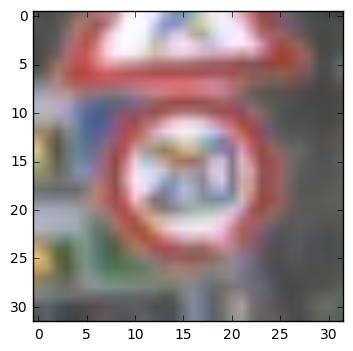

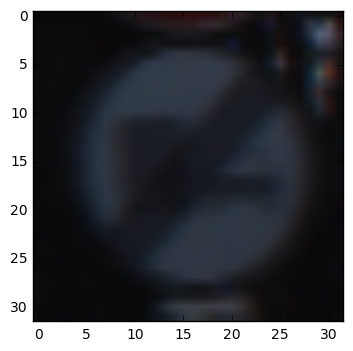

In [62]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
#print(X_train[0])



print(X_train[0,0,0,:])


# Show first and last image in database.
plt.imshow(X_train[0])
plt.show()

plt.imshow(X_train[39208])
plt.show()

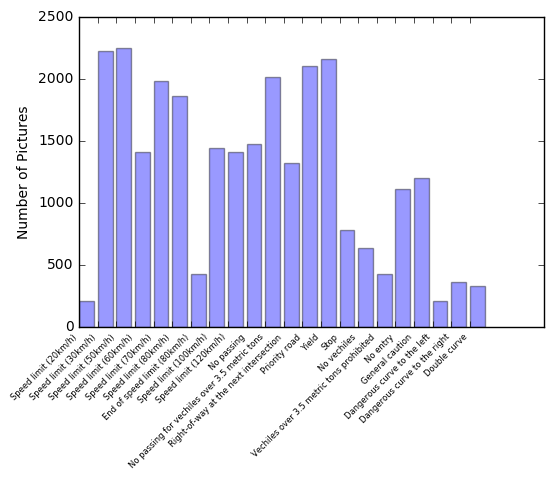

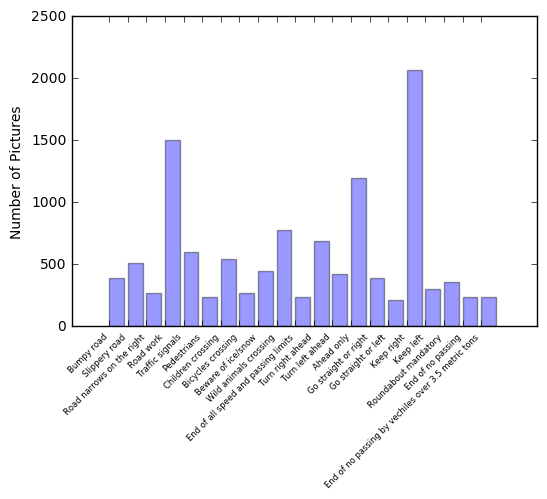

In [63]:
# Print number of each class

#print( y_train )

#print( len(np.bincount(y_train)) )

#print( np.bincount(y_train) )


signnameslist = []
with open('signnames.csv') as csvfile:
    signnames = csv.DictReader(csvfile)
    for row in signnames:
        signnameslist.append(row['SignName'])
        
#print(signnameslist)
        
y_pos = np.arange(len(signnameslist))
number_sign = np.bincount(y_train)


barhstart = 0
barhend = 22
plt.bar(y_pos[barhstart:barhend],number_sign[barhstart:barhend], alpha=0.4)
plt.xticks(y_pos[barhstart:barhend], signnameslist[barhstart:barhend], rotation=45, horizontalalignment='right',size=6)
plt.ylabel('Number of Pictures')


#plt.tight_layout()
plt.show()

barhstart = 22
barhend = 43
plt.bar(y_pos[barhstart:barhend],number_sign[barhstart:barhend], alpha=0.4)
plt.xticks(y_pos[barhstart:barhend], signnameslist[barhstart:barhend], rotation=45, horizontalalignment='right',size=6)
plt.ylabel('Number of Pictures')


#plt.tight_layout()
plt.show()



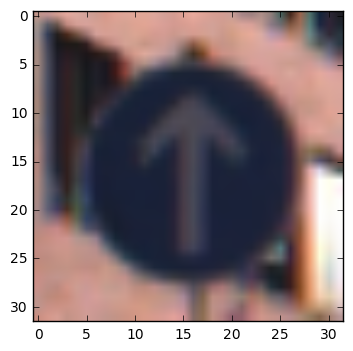

In [64]:
# Look at the first image in each class. Enter 0 to 42.


plt.imshow(X_train[np.sum(number_sign[0:35])+50])
plt.show()

From the graphs it can be seen that even though there are almost 40,000 images in the training database, some signs have less than 500 examples that can be used. It should be reasonable to expect that the accuracy of predicting these signs would be much lower than signs that have 1,500 or 2,000 training images.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 1  - Preprocess

_Describe the techniques used to preprocess the data._

In [65]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.


# Not used in final classifier, full color image is used instead.
def grayscale(img):
    #call plt.imshow(gray, cmap='gray')
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

X_train_gray = np.zeros( (len(X_train), len(X_train[0]), len(X_train[0,0]), 1 ), dtype='uint8' )
X_test_gray = np.zeros( (len(X_test), len(X_test[0]), len(X_test[0,0]) , 1 ), dtype='uint8' )




for i in range( len(X_train) ):
    X_train_gray[i,:,:,0] = grayscale(X_train[i])

for i in range( len(X_test) ):
    X_test_gray[i,:,:,0] = grayscale(X_test[i])
    

print(X_test_gray[0,0,0,:])


[147]


In [66]:
## Normalize data, use a and b values from lab.

def normalize_image(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    # ToDo: Implement Min-Max scaling for greyscale image data
    grey_max = 255
    grey_min = 0
    a = 0.1
    b = 0.9
    
    norm_image_data = a + ( (image_data - grey_min)*(b - a)/(grey_max - grey_min) )
    
    return norm_image_data

X_train_norm = np.zeros( (len(X_train), len(X_train[0]), len(X_train[0,0]), 3 ), dtype='float32' )
X_test_norm = np.zeros( (len(X_test), len(X_test[0]), len(X_test[0,0]), 3 ), dtype='float32' )

for i in range( len(X_train) ):
    X_train_norm[i] = normalize_image(X_train[i])
    #X_train_norm[i] = normalize_image(X_train_gray[i])

for i in range( len(X_test) ):
    X_test_norm[i] = normalize_image(X_test[i])

print( X_train[0,0,:,2] )
print( X_train_norm[0,0,:,2] )
print( '\n')
print( X_test[0,0,:,2] )
print( X_test_norm[0,0,:,2] )

[ 80  78  83  85 102 114 117 124 150 230 255 255 255 212 182 175 181 203
 238 251 227 181 119  74  80 100 103  90  78  73  68  66]
[ 0.3509804   0.34470588  0.36039215  0.36666667  0.41999999  0.45764706
  0.46705884  0.4890196   0.57058823  0.82156861  0.89999998  0.89999998
  0.89999998  0.76509804  0.67098039  0.6490196   0.66784316  0.73686272
  0.84666669  0.88745099  0.81215686  0.66784316  0.47333333  0.33215687
  0.3509804   0.4137255   0.42313725  0.38235295  0.34470588  0.32901961
  0.31333333  0.30705881]


[174 171 172 175 171 168 169 168 162 152 175 176 172 163 163 172 148 156
 159 165 166 152 155 157 156 154 153 127 147 143 147 130]
[ 0.64588237  0.63647062  0.63960785  0.6490196   0.63647062  0.6270588
  0.63019609  0.6270588   0.6082353   0.57686275  0.6490196   0.65215689
  0.63960785  0.61137253  0.61137253  0.63960785  0.56431371  0.58941174
  0.59882355  0.61764705  0.62078434  0.57686275  0.5862745   0.59254903
  0.58941174  0.58313727  0.57999998  0.49843138  0.56

In [67]:
## One Hot Encoding of labels

# Test

encoder = LabelBinarizer()
testlabel = np.arange(10)
testlabel = np.append(testlabel,(5,1,2))
encoder.fit(testlabel)
testlabel = encoder.transform(testlabel)

print(testlabel)
print('\n')

encoder = LabelBinarizer()
encoder.fit( y_train )
y_train = encoder.transform( y_train )

y_train = y_train.astype(dtype='float32')

print( y_train )

encoder = LabelBinarizer()
encoder.fit( y_test )
y_test = encoder.transform( y_test )

y_test = y_test.astype(dtype='float32')
print( '\n' )
print( y_test )


[[1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]]


[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]]


[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


**Question 1 Answer:**

The pipeline used for the images first converts the images to grayscale. Looking through the images for each class, there are no signs which are only differentiated based on the color. Based on this I decided to reduce all the images to grayscale to reduce the number of features that the classifier would have to worry about. Removing the extra color data will reduce the information for each pixel by 1/3 (since the three RGB values for each pixel are now just one value). This will reduce the computation time of the entire neural network since its working with less data.

I'm aware that this change could have a negative effect as there clearly are signs that are different colors (Stop sign vs Ahead Only sign) and taking away this extra info could make differentiation more difficult for some of these cases. However, the signs which most closely resemble each other (and thus most need the extra information the most), such as 20, 30, 50, 60 km/h, color provides no information that grayscale doesn't. If I'm having trouble differentiating between Stop signs and another color sign I can remove the grayscale preprocess step, but I'm doubting that will happen.

> Changed after project submission. Going to use full color data in attempt to achieve higher test accuracy.

The second image preprocess step is to normalize all of the values. Normalization is performed so that all of the values have roughly equal variance. This also reduces the overall size of the numbers which can be beneficial when working with large numbers so that the error from the least significant bit doesn't become large relative to weights and other values. Having a small mean and equal variance for all features can greatly help the optimizer as the path it takes during gradient descent is consistent in all directions. Since it is known that the max value a grayscale image can have is 255 and the minimum value is 0, the values can be normalized so that all values are between 0 and 1. The alpha and beta numbers were taken from the suggested values in the intro to Tensor flow lab.

The labels for each image were in row vector form where each column had a number ranging from 0 to 42. This number respresented the label for each image. The labels were one hot encoded which turned them into a matrix with 43 columns. Each column represented the label and each row was all zeros except for a 1 in the column which indicated the correct label.


### Question 2 - Training, Validation, Testing



_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

In [104]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

train_features, valid_features, train_labels, valid_labels = train_test_split(
    X_train_norm,
    y_train,
    test_size=0,
    random_state=1336)

print( str(len(y_train)) + ' - '+ str(len(train_labels)) + ' = ' + str(len(valid_labels)))

print(train_features[0,0,0,:])

39209 - 39209 = 0
[ 0.18470588  0.21294117  0.30705881]


In [105]:
# Save the data for easy access
pickle_file = 'preprocdata.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open('preprocdata.pickle', 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': train_features,
                    'train_labels': train_labels,
                    'valid_dataset': valid_features,
                    'valid_labels': valid_labels,
                    'test_dataset': X_test_norm,  
                    'test_labels': y_test,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Saving data to pickle file...
Data cached in pickle file.


In [106]:
print(len(X_test_norm))
print(len(train_features))
print(len(valid_features))

12630
39209
0


**Question 2 Answer:**

After all the processing mentioned above, the training data was split 90/10 into training and validation data. The test data isn't used as validation data so that it can be used as a final test which had no influence on the design of the classifier. Even though the validation data is never directly seen by the classifier, it still is impacted by me seeing how the classifier is performing on the validation data and making changes to the classifier based on that.

The number of images in each data set is given below: 

**Training** $\approx$ 35,300

**Validation** $\approx$ 3,900

**Testing** $\approx$ 12,600



I did not generate additional data as I plan to use the dropout method and carefully selecting the number of epochs based on the results of the validation data inorder to prevent over fitting of the model.

In [107]:
# Test importing all required packages
import tensorflow as tf
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import csv
import cv2
import os
import pickle
from tqdm import tqdm
import math
import time
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.layers import Convolution2D, MaxPooling2D
from sklearn.metrics import classification_report

print('Modules loaded successfully.')

Modules loaded successfully.


In [108]:
# Reload the data
pickle_file = 'preprocdata.pickle'
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  train_features = pickle_data['train_dataset']
  train_labels = pickle_data['train_labels']
  valid_features = pickle_data['valid_dataset']
  valid_labels = pickle_data['valid_labels'] 
  test_features = pickle_data['test_dataset']
  test_labels = pickle_data['test_labels']
  del pickle_data  # Free up memory

    
print('Data and modules loaded.')


Data and modules loaded.


In [110]:
# Check to ensure data is displaying correctly.

print(train_features[0,0,0,:])
#print(valid_features[0,0,0,:])
print(test_features[0,0,0,:])

print(train_labels[:,0])
#print(valid_labels[:,0])
print(test_labels[:,0])

[ 0.18470588  0.21294117  0.30705881]
[ 0.46392158  0.53607845  0.64588237]
[ 0.  0.  0. ...,  0.  0.  0.]
[ 0.  0.  0. ...,  0.  0.  0.]


## Keras NN

In [111]:
# Convolution kernal final size.
kernal_size = 3

# Convolutional filters.
nb_filters = 16
pool_size = (2,2)
input_shape = (32,32,3)

model = Sequential()

# First convolution layer with relu activation, max pooling, and dropout.
model.add(Convolution2D(nb_filters, kernal_size*2, kernal_size*2,
                        border_mode = 'same',
                        input_shape = input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.25))

# Second convolution layer with relu, max pooling, and dropout.
model.add(Convolution2D(nb_filters*2, kernal_size, kernal_size,
                        border_mode = 'same',
                        input_shape = input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size))
model.add(Dropout(0.5))

# Third convolution layer with relu, max pooling, and dropout.
model.add(Convolution2D(nb_filters*4, kernal_size, kernal_size,
                        border_mode = 'same',
                        input_shape = input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size))
model.add(Dropout(0.5))

# First fully connected deep layer.
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Final dense layer.
model.add(Dense(43))
model.add(Activation('softmax'))

model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_25 (Convolution2D) (None, 32, 32, 16)    1744        convolution2d_input_9[0][0]      
____________________________________________________________________________________________________
activation_37 (Activation)       (None, 32, 32, 16)    0           convolution2d_25[0][0]           
____________________________________________________________________________________________________
maxpooling2d_25 (MaxPooling2D)   (None, 16, 16, 16)    0           activation_37[0][0]              
____________________________________________________________________________________________________
dropout_33 (Dropout)             (None, 16, 16, 16)    0           maxpooling2d_25[0][0]            
___________________________________________________________________________________________

In [113]:
nb_epoch = 15

prevepoch = 5
print('Before this there was', prevepoch, 'epochs.')

batch_size = 50 

starttime = time.clock()

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['categorical_accuracy'])

history = model.fit(train_features, train_labels,
                    batch_size = batch_size, nb_epoch = nb_epoch,
                    verbose = 1, validation_split = 0.15)

elapsedtime = time.clock() - starttime

print('%.1f minutes.\n\n' %(elapsedtime/60))




Before this there was 5 epochs.
Train on 33327 samples, validate on 5882 samples
Epoch 1/15
33327/33327 [==============================] - 4s - loss: 0.5196 - categorical_accuracy: 0.8271 - val_loss: 0.2254 - val_categorical_accuracy: 0.9396
Epoch 2/15
33327/33327 [==============================] - 4s - loss: 0.4737 - categorical_accuracy: 0.8428 - val_loss: 0.2038 - val_categorical_accuracy: 0.9427
Epoch 3/15
33327/33327 [==============================] - 4s - loss: 0.4377 - categorical_accuracy: 0.8562 - val_loss: 0.1764 - val_categorical_accuracy: 0.9488
Epoch 4/15
33327/33327 [==============================] - 4s - loss: 0.4147 - categorical_accuracy: 0.8617 - val_loss: 0.1334 - val_categorical_accuracy: 0.9634
Epoch 5/15
33327/33327 [==============================] - 4s - loss: 0.3692 - categorical_accuracy: 0.8759 - val_loss: 0.1097 - val_categorical_accuracy: 0.9747
Epoch 6/15
33327/33327 [==============================] - 4s - loss: 0.3701 - categorical_accuracy: 0.8767 - val_l

In [117]:
# Test accuracy.
testacc = model.evaluate(test_features, test_labels)

print(testacc)

12480/12630 [============================>.] - ETA: 0s[0.32309666494481259, 0.90261282662220255]


Everything below is part of an assignment I submitted. Originally I used a Tensor flow NN to classify images. In an attempt to achieve a higher test accuracy I have switched to Keras and increased the number of layers which is the code you see above.

### Question 3 - Tensor Flow CNN

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


In [7]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
# Code modified from "Deep MNIST for Experts" tutorial which had already developed the type of network
# I was looking to build which was: a few alternating convolution and pooling layers capped off by a few densely
# connected layers.

tf.reset_default_graph()

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x,W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x,ksize=[1,2,2,1],
                         strides=[1,2,2,1], padding='SAME')

# Convolution Layer 1 with pooling
#x = tf.placeholder(tf.float32, [None, 32*32])
x = tf.placeholder(tf.float32, shape=[None, 32, 32,3])
y_ = tf.placeholder(tf.float32, [None, 43])

W_conv1 = weight_variable([5, 5, 3, 32]) # 32 features for each 5x5 patch
b_conv1 = bias_variable([32])

#x_image = tf.reshape(x, [-1,32,32,3])

h_conv1 = tf.nn.relu( conv2d(x, W_conv1) + b_conv1) # First layer output.
h_pool1 = max_pool_2x2(h_conv1) # apply max pooling after each conv layer.


# Convolution Layer 2 with pooling
W_conv2 = weight_variable([5, 5, 32, 64]) # 5x5 patch, 64 features.
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu( conv2d(h_pool1, W_conv2) + b_conv2 )
h_pool2 = max_pool_2x2( h_conv2 ) 

# Because the image has been pooled at 2x2 twice, the image size is now 32/(2*2) = 8. Image size is 8x8x3.
# Densely Connected Layer 3 with 1024 neurons.
W_fc1 = weight_variable([8*8*64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape( h_pool2, [-1, 8*8*64])
h_fc1 = tf.nn.relu( tf.matmul( h_pool2_flat, W_fc1) + b_fc1)


# Dropout to increase redundancy and reduce overfitting.
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout( h_fc1, keep_prob)

# Softmax Layer 4 to output probabilities. Output must be 43. 
W_fc2 = weight_variable([1024, 43])
b_fc2 = bias_variable([43])

y_conv = tf.nn.softmax( tf.matmul( h_fc1_drop, W_fc2) + b_fc2)

print('Got here.')

Got here.


**Question 3 Answer:**

When looking through the sample images I noticed that even though the image size is 32x32 throughout the entire database, the size of the sign changes even for the same sign label. So for example, one 20 km/h sign might take up almost the entire image while another may be much smaller and shifted towards the bottom right corner. In convolution lectures we learned that if what you are looking for is "translation invariant" then convolution networks can be very effective at disregarding the difference in location for what you are looking for. A convolution network would solve the problem of one sign taking up the whole image while another sign of the same label is mainly in the bottom corner. This is why I decided to build a convolution network.

In the next few lectures it was mentioned that a very powerful network setup for a convolutional network is few layers alternating convolution and max pooling which increase the "depth" (outputs) but decrease the entire image size. The final layer of my network is a softmax layer which takes the output from the dropout layer and assigns a probability for each label.



### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


In [8]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Model Training and Evaluating
batch_size = 50
epochs = 10

# Feed dicts for training, validation, and test session
train_feed_dict = {x: train_features, y_: train_labels, keep_prob: 1.0}
valid_feed_dict = {x: valid_features, y_: valid_labels, keep_prob: 1.0}
test_feed_dict = {x: test_features, y_: test_labels, keep_prob: 1.0}

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal( tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean( tf.cast(correct_prediction, tf.float32) )

In [ ]:
# Run
saver = tf.train.Saver()

sess = tf.InteractiveSession()

sess.run(tf.initialize_all_variables())

batch_count = int(math.ceil(len(train_features)/batch_size)) 
for epoch_i in range(epochs):
    # Progress bar
    batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
    # The training cycle
    for batch_i in batches_pbar:
        # Get a batch of training features and labels
        batch_start = batch_i*batch_size
        batch_features = train_features[batch_start:batch_start + batch_size]
        batch_labels = train_labels[batch_start:batch_start + batch_size]
        
        #if batch_i % 30000 == 0:
            #valid_accuracy = accuracy.eval(valid_feed_dict)
            #print("\n Validation accuracy %g" %(valid_accuracy))
            
        
        train_step.run(feed_dict = {x: batch_features, y_: batch_labels, keep_prob: 0.5})
    
    valid_accuracy = accuracy.eval(valid_feed_dict)
    print("\n Validation accuracy %g" %(valid_accuracy))
    #print("Test accuracy %g"%accuracy.eval(test_feed_dict))
    time.sleep(1)

    
save_path = saver.save(sess, "color-model.ckpt")
print("Model saved in file: %s" % save_path)
    
print('fin')

In [10]:
print("Valid accuracy %g"%accuracy.eval(valid_feed_dict))

Valid accuracy 0.00535578


In [11]:
print("Test accuracy %g"%accuracy.eval(test_feed_dict))

Test accuracy 0.00475059


In [ ]:
#print("Train accuracy %g"%accuracy.eval(train_feed_dict))

Model restored.


Guess Probability: 0.104113 %
Sign Name: Wild animals crossing


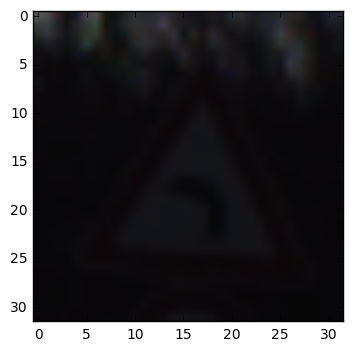

Guess Probability: 1.0 %
Sign Name: Yield


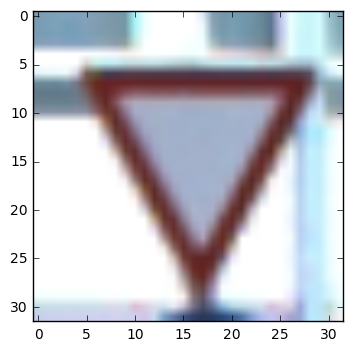

Guess Probability: 0.982143 %
Sign Name: Keep right


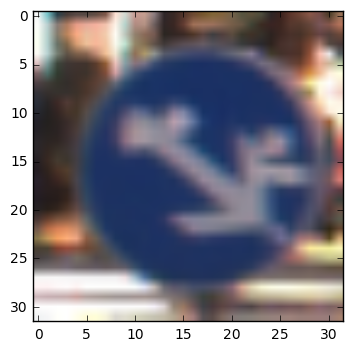

Guess Probability: 0.757778 %
Sign Name: Speed limit (70km/h)


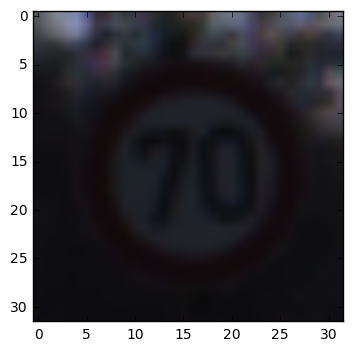

Guess Probability: 0.312387 %
Sign Name: Ahead only


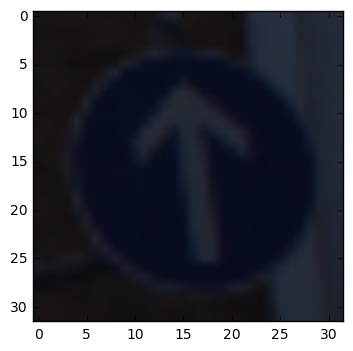

Guess Probability: 0.999997 %
Sign Name: Road work


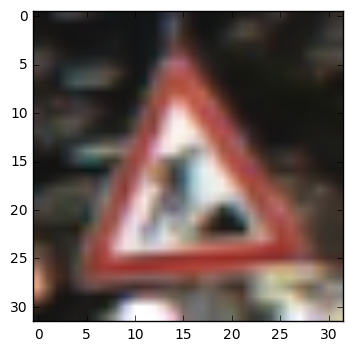

Guess Probability: 0.999778 %
Sign Name: Turn left ahead


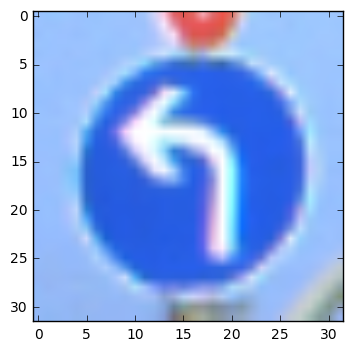

Guess Probability: 0.319825 %
Sign Name: Priority road


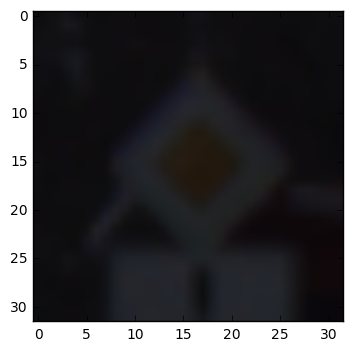

Guess Probability: 0.99999 %
Sign Name: No entry


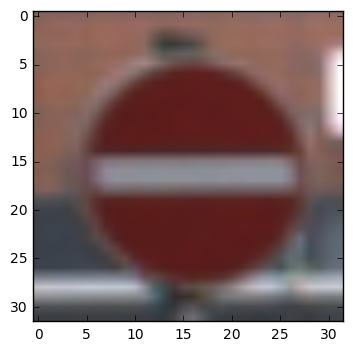

Guess Probability: 0.976852 %
Sign Name: No passing


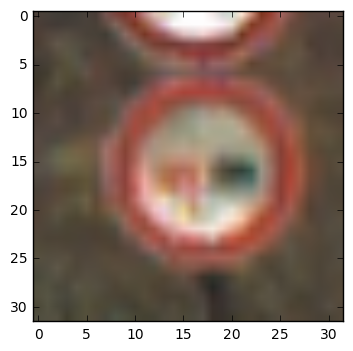

In [24]:
imnum = 380



saver = tf.train.Saver()

with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "31e-model.ckpt")
    print("Model restored.")
    #print(y_conv)
    #print("Valid accuracy %g"%accuracy.eval(valid_feed_dict))
    #print("Test accuracy %g"%accuracy.eval(test_feed_dict))
    
    feed_dict = {x: X_test_norm[imnum:imnum+10], keep_prob: 1.0}
    classificationout = sess.run(y_conv, feed_dict)
    #print( classificationout[0] )
        
    predictionout=tf.argmax(y_conv,1)
    prednum = predictionout.eval(feed_dict={x: X_test_norm[imnum:imnum+10], keep_prob: 1.0})
    
    #print(prednum)
    
    print('\n')
    
    for i in range(0, 10):
        guessprob = classificationout[i,prednum[i]]
        print('Guess Probability: ' + str(guessprob) + ' %')

        print('Sign Name: ' + signnameslist[prednum[i]])
    
        #correct_prediction = tf.equal( tf.argmax(y_conv,1), tf.argmax(y_test[imnum:imnum+1],1))
        #accuracy = tf.reduce_mean( tf.cast(correct_prediction, tf.float32) )
        #print(accuracy.eval(feed_dict={x: X_test_norm[imnum:imnum+1], y_: y_test, keep_prob: 1.0}))
    
        plt.imshow(X_test[imnum+i])
        plt.show()
    
    

**Question 4 Answer:**
optimizer batch size epochs and hyper paramters.

For training my model I used an ADAM optimizer as reccomended by the Deep MNIST tutorial for experts. The ADAM optimizer reduces the number of hyper parameters that I need to set as it uses its own internal algorithms to control the learning rate. It also adds momentum to the descent to help prevent the optimizer from getting stuck in a local minimum. It does require more computation than the gradient descent function but this should be offset since my overal neural network is only a few layers deep.

The batch size and the epoch to me have a very direct relationship. In most cases if you chose a smaller batch size, you won't need as many epochs since in each epoch you will have more learning descents. However, even though I was quite happy with how fast computationaly a batch size of 50 was able to converge. I found that my validation error was only getting to about 90% before it would begin overfitting and drop dramatically. I felt that because there are 43 labels, and there is a very uneven distribution between all the labels (as shown in the visualization section), that it would be better to increase the batch size so that in each batch there was a greater chance that there was multiple images from each label in the batch which could help prevent the learning only focusing on the most common labels. In order to get the same learning achived with a large batch size would mean that I would have to increase the number of epochs. However I found that even though my learning rate much was slower, I was able to push past well into 95% validation accuracy when taking this slower approach.

My final model had a batch size of 500 ($\approx$ 10x label$_{\mathrm{num}}$) and at 30 epochs I had my maximum validation accuracy. As shown by the per epoch print out below, after $\approx$ 30-32 epochs, the validation accuracy would plummet as the model began to overfit the data.

Epoch 31/45: 100%|██████████| 71/71 [01:02<00:00,  1.30batches/s]


 Validation accuracy 0.961999

Epoch 32/45: 100%|██████████| 71/71 [01:02<00:00,  1.29batches/s]


 Validation accuracy 0.96557

Epoch 33/45: 100%|██████████| 71/71 [01:01<00:00,  1.32batches/s]


 Validation accuracy 0.00535578

Epoch 34/45: 100%|██████████| 71/71 [01:00<00:00,  1.33batches/s]


 Validation accuracy 0.00535578
 

The other hyper parameter I had to worry about was the dropout rate and I found little difference when changing this from its 50%.

My models final validation accuracy was 95.92%.

This yielded a test accuracy 86.92%. Even though a drop in accuracy in the test database compared to the training/validation is expected, this drop seems much larger that what I expected. Looking through some of the test images however they appeared much more difficult than the training and validation set. Just looking through the images it seemed as though there was a great deal of incredibly dark images and some which were so blurry that I couldn't even discern what they were by looking at them. This could be purely dumb luck however because since there are 35,000 and 12,000 images respecitvely in each, its nearly impossible to get a feel for the two image sets by looking at a few hundred images. If the test and training set are of similar difficulty I'm not sure why there is such a large difference.

Its hard to know exactly what is causing the drop. The test validation set does have the same rough distribution between the labels as the training set. An interesting area of further study could be training the same network purely on the test data and applying the solution to the training data and see what the accuracy is between the two. Perhaps I'll undertake that after I submit this assignment.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

Since this is my first time designing a complete neural network (the Tensor flow lab doesn't really count because most of the code was already in place I just had to fill in a few blanks), I didn't want to be hopelessly messing around inside a giant parameter space for days on end. I decided to start with what was reccomended as a small but proven neural network structure that was suggested by the convolution lectures. I then dropped the level of complexity down slightly (from two densely connected layer after the convolution to one) as the computation time was getting extremely long and started from there. With this simple network I was able to achieve extremely promsing results. For all the "clear" sign images, my network performs perfectly. It is only when the images are dark or barely discernable to a human that it starts to fail.

That being said it can still predict specific dark or even extremely blurry images, just not at the 99.9% accuracy rate that other networks have. However given my limited hardware and limited time, (as of writing this I've already put 20 hours into this project which is way more than the reccomended 8 hours and I haven't started step 3 yet) I am extremely happy with my results.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [25]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.


# Load images
self_img = np.zeros((5,32,32,3), dtype='uint8')

self_img[0,:,:,:] = mpimg.imread('photos/0.jpg')
self_img[1,:,:,:] = mpimg.imread('photos/2.jpg')
self_img[2,:,:,:] = mpimg.imread('photos/3.jpg')
self_img[3,:,:,:] = mpimg.imread('photos/4.jpg')
self_img[4,:,:,:] = mpimg.imread('photos/5.jpg')

self_img_gray = np.zeros((5,32,32,1), dtype='uint8')

# Grayscale
for i in range( len(self_img) ):
    self_img_gray[i,:,:,0] = grayscale(self_img[i])
    
self_img_norm = np.zeros((5,32,32,1), dtype='float32')
    
# Normalize
for i in range( len(self_img_gray) ):
    self_img_norm[i] = normalize_greyscale(self_img_gray[i])
    
print(self_img_gray[0,:,0,0])
print(self_img_norm[0,:,0,0])


print('Preprocess done.')

[ 75  63  54  79 100  99 122 112  65  79 118 102 115 124  85  90  64  61
  56  62 163 126 157 177 134 100 110 130 186 153 155 211]
[ 0.33529413  0.29764706  0.26941177  0.34784314  0.4137255   0.41058823
  0.48274511  0.45137256  0.30392158  0.34784314  0.47019607  0.41999999
  0.46078432  0.4890196   0.36666667  0.38235295  0.30078432  0.29137254
  0.27568626  0.2945098   0.61137253  0.49529412  0.59254903  0.65529412
  0.52039218  0.4137255   0.44509804  0.50784314  0.68352944  0.57999998
  0.5862745   0.7619608 ]
Preprocess done.


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Question 6 Answer:**

Since I live in Canada, most of my road signs look nothing like the German verions. The difference between the signs should make the classification more difficult even though the pictures are in clear daylight and taken head on. Even the stop sign, while the shape is the same and both have the word "STOP" on them, the different font and size of the letters make the two signs quite different. Even the yield signs are quite different. German yield signs have a thin red boarder around the triangle while the Canadian version is quite thick.

I'm guessing that the stop sign will still work just won't have as high as a probability as a german sign. 

I'm guessing that the 3.5 ton truck sign (even though in Canada the green ring signifies allowed not prohibited) will be extremely hard for the model give the fact that the two truck pictures aren't the same. The German version has a completely different front end.

For the road work sign even though the picture of the worker in the center is really close to the German version, the outside is not in a triangle but a square which could drop the probability considerably. However there aren't very many signs with a similar inside so I'm guessing it still predicts it just with a very low probability.

Even though as I said the Canadian yield sign is much thicker around the boarder, the model should still predict it fine.

Our speed limit signs are considerably different. They have the text "MAXIMUM" and "KM/H" in them and are in a rectangle as opposed to a circle. I'm guessing this will still work as the letters 50 are clearly visible in the picture.

Model restored.
[14 16 25 13  1]


Guess Probability: 47.8902131319 %
Guess Sign Name: Stop


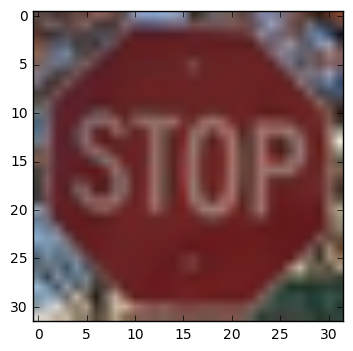

Guess Probability: 98.2778847218 %
Guess Sign Name: Vechiles over 3.5 metric tons prohibited


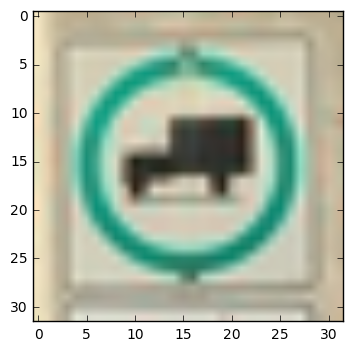

Guess Probability: 36.2943887711 %
Guess Sign Name: Road work


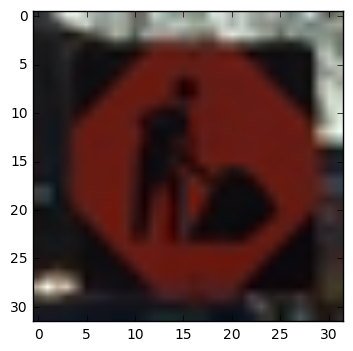

Guess Probability: 100.0 %
Guess Sign Name: Yield


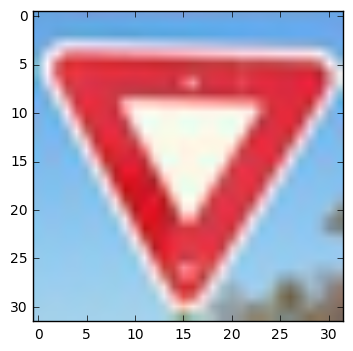

Guess Probability: 23.029191792 %
Guess Sign Name: Speed limit (30km/h)


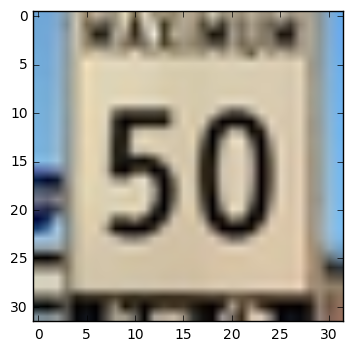

Correct Probability: 2.17699296772 %
All Probabilities:

[  1.74052212e-02   2.30291918e-01   2.17699297e-02   1.40484408e-01
   1.27863586e-05   1.27611903e-03   2.63054427e-02   1.61369579e-04
   1.34708313e-03   5.77193496e-05   1.00662060e-01   8.31786165e-05
   1.74293920e-04   4.06869585e-05   1.68457612e-01   1.61377770e-07
   4.48155263e-03   3.17298472e-02   9.48670788e-07   1.60059854e-02
   1.61361019e-03   2.14390195e-04   1.18425905e-05   2.73537473e-04
   1.11390560e-04   8.23170841e-02   1.24997399e-07   4.76170790e-05
   4.71407286e-04   1.27435743e-03   8.86679481e-05   1.18522512e-05
   1.82226626e-03   3.97518603e-03   7.10625341e-03   7.19075054e-02
   4.86150794e-02   2.59755761e-04   1.34390348e-03   2.46045474e-05
   3.46023752e-03   2.01038260e-04   1.41000338e-02]


In [26]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

imnum = 0


saver = tf.train.Saver()

with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "31e-model.ckpt")
    print("Model restored.")
    #print(y_conv)
    #print("Valid accuracy %g"%accuracy.eval(valid_feed_dict))
    #print("Test accuracy %g"%accuracy.eval(test_feed_dict))
    
    feed_dict = {x: self_img_norm[imnum:imnum+5], keep_prob: 1.0}
    classificationout = sess.run(y_conv, feed_dict)
    #print( classificationout[0] )
        
    predictionout=tf.argmax(y_conv,1)
    prednum = predictionout.eval(feed_dict={x: self_img_norm[imnum:imnum+5], keep_prob: 1.0})
    
    print(prednum)
    
    print('\n')
    
    for i in range(0, 5):
        guessprob = classificationout[i,prednum[i]]
        print('Guess Probability: ' + str(guessprob*100) + ' %')

        print('Guess Sign Name: ' + signnameslist[prednum[i]])
    
        #correct_prediction = tf.equal( tf.argmax(y_conv,1), tf.argmax(y_test[imnum:imnum+1],1))
        #accuracy = tf.reduce_mean( tf.cast(correct_prediction, tf.float32) )
        #print(accuracy.eval(feed_dict={x: X_test_norm[imnum:imnum+1], y_: y_test, keep_prob: 1.0}))
    
        plt.imshow(self_img[imnum+i])
        plt.show()
        
    guessprob = classificationout[4,2]
    print('Correct Probability: ' + str(guessprob*100) + ' %')
    guessprob = classificationout[4,:]
    print('All Probabilities:\n')
    print(guessprob)

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

All of my model predictions are correct except for the 50 speed limit. I find this extremely odd as it must mean that the dependance on non-text factors of the sign are incredibly important. I'm not sure how the "Ahead Only" sign, which is a circular sign with a giant arrow point upward, got such a high probabiltiy. 

I'm really surprised that the Road Work sign, while having similar inside image (though not identical) and a completely different sign shape, mangaged to still correctly predict the right sign with a probability of 40%.

Another interesting note is how much the different font for "STOP" hurts the prediction for that sign. If that was a German sign with the same quality of lighting and looking head on into the sign, the probability would easily be above 99% based on some of the tests I did in Question 4.

Below is a summary of all the new image guess probability with similar images (similar lighting and blurryness) from the test set.

    Sign Name      | New Image Guess | Test Set Guess  | Possible Reason
    ................................................................
    Stop Sign      | 58.837 %        | 99.976 %        | German sign has thicker white boarder compared to Canadian.
    3.5 Metric Ton | 99.554 %        | 99.991 %        | Vehcile shape is the same but has a few different lines.
    Road Work      | 38.286 %        | 99.999 %        | Sign shape is different but inner picture is similar.
    Yield Sign     | 99.999 %        | 99.999 %        | Even though the boarder is slightly thinner same whole shape.
    50 km/h        | Detailed further in question 8.
                                                        

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

For the 50 km/h sign, it only guessed 0.3% on the correct label. However a number of similar speed signs made the top 3 which are:

30 km/h at 17%

60 km/h at 27%

Ahead Only at 31%

The 60 km/h makes a great deal of sense having a high probability like 27% considering that a 6 and a 5 only have that left vertical line separating them. However I'm still not sure why the 50 km/h sign only had a .3% probabiltiy while the Ahead Only sign, which looks nothing like it has 31%. 

There must be some feature that is extremely heavily weighed for in the Ahead Only sign, such as the arrow head, which potentially shows up in the "MAXIMUM" text or somewhere else in the Canadian 50 km/h sign.


Below the top 5 softmax probabilties for the stop sign, road work, and 50 km/h signs are plotted. The yield and 3.5 metric ton sign weren't plotted because their guess probabilities were so high, that its meaningless which classifications came 2nd through 5th.

For the Road work sign it seems wrong that the Ahead Only sign is 2nd despite that sign looking nothing like the road work sign. The 3.5 metric tons sign makes sense being in the top 5 as it is also a sign that has a great deal of edges and different shapes inside of the sign. I feel like the yield sign is in the top 5 because of the diamond shape the orange part of the sign has which closely resembles the bottom point of the yield sign.


The stop sign while not having a very strong probability, is a clear winner with the next closest value having 1/6th of the probabiltiy. The signs that place 2nd through 5th do make sense as they are signs with lots of text or shapes inside of the sign. A blank sign like the yield sign would not make sense being in the top 5 predictions.



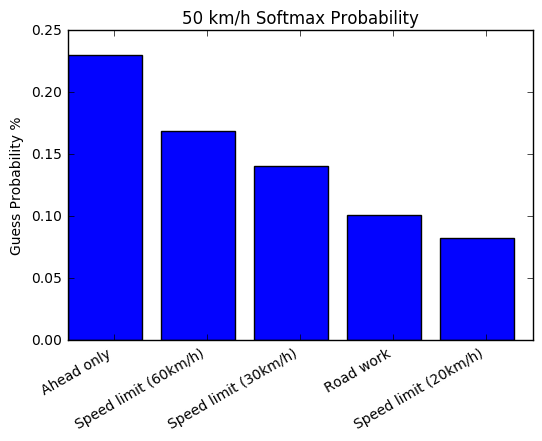

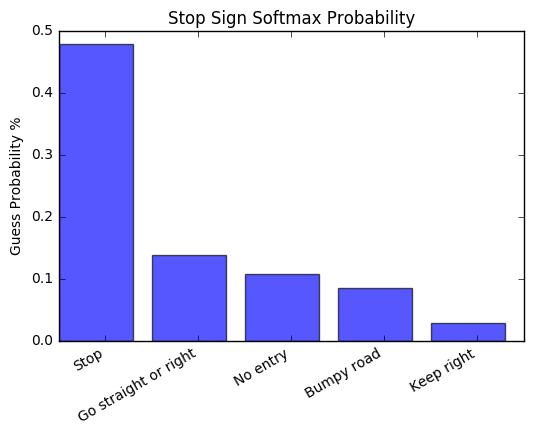

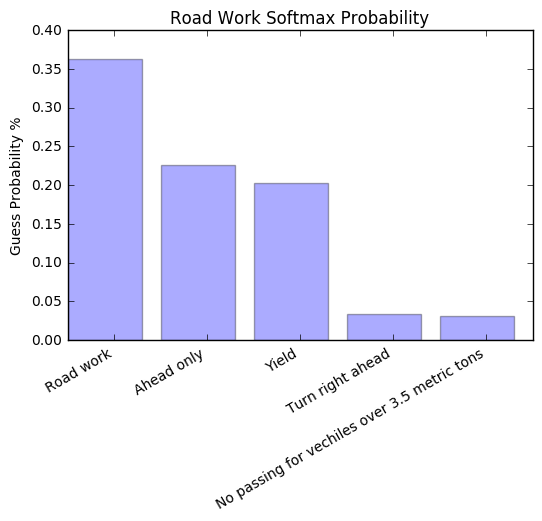

In [28]:
## Visualization of Softmax Probabilities
import heapq

values = heapq.nlargest(5, classificationout[4,:])
stopsignname = [signnameslist[35], signnameslist[3], signnameslist[1], signnameslist[25], signnameslist[0]]
plt.bar(np.arange(0,5),values, alpha=.99)
plt.xticks(np.arange(0.5,5.5), stopsignname, rotation=30, horizontalalignment='right',size=10)
plt.ylabel('Guess Probability %')
plt.title('50 km/h Softmax Probability')

plt.show()

values = heapq.nlargest(5, classificationout[0,:])
stopsignname = [signnameslist[14], signnameslist[36], signnameslist[17], signnameslist[22], signnameslist[38]]
                
plt.bar(np.arange(0,5),values, alpha=.66)
plt.xticks(np.arange(0.5,5.5), stopsignname, rotation=30, horizontalalignment='right',size=10)
plt.ylabel('Guess Probability %')
plt.title('Stop Sign Softmax Probability')

plt.show()




values = heapq.nlargest(5, classificationout[2,:])
stopsignname = [signnameslist[25], signnameslist[35], signnameslist[13], signnameslist[33], signnameslist[10]]
plt.bar(np.arange(0,5),values, alpha=0.33)
plt.xticks(np.arange(0.5,5.5), stopsignname, rotation=30, horizontalalignment='right',size=10)
plt.ylabel('Guess Probability %')
plt.title('Road Work Softmax Probability')

plt.show()



